In [1]:
import fdapdepy as fdapde
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation

In [2]:
# mesh
nodes = np.loadtxt("unit_square/points.txt", dtype=float)
triangles = np.loadtxt("unit_square/elements.txt", dtype=int)
triangles = triangles - 1 # sempre stessa storia
boundary = np.loadtxt("unit_square/boundary.txt", dtype=int)
nodes.shape
mesh = fdapde.cpp_domain_2d(nodes, triangles, boundary)

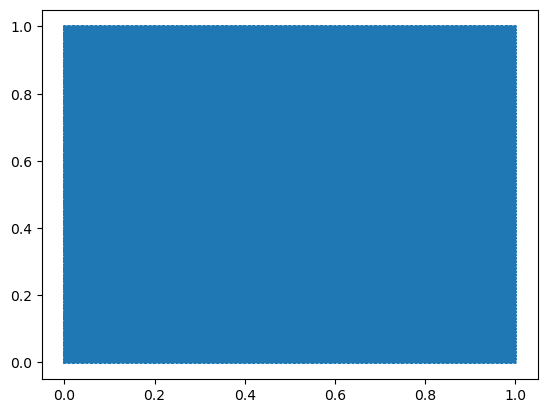

In [3]:
triangulation = Triangulation(mesh.nodes()[:,0], mesh.nodes()[:,1], mesh.triangles())

fig, ax = plt.subplots()
ax.triplot(triangulation)

In [ ]:
import scikit_build_example as example 